<a href="https://colab.research.google.com/github/arzhrd/Basketball-Player-Detail-Using-Computer-Vision/blob/main/Basketball_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Configure API Keys and check for GPU
import os
from google.colab import userdata
from pathlib import Path
import torch

# Load API keys from Colab secrets
try:
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
    os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")
    print("API keys loaded successfully.")
except Exception as e:
    print("Could not load API keys. Please set them up in Colab Secrets (🔑).")
    print("Required secrets: 'HF_TOKEN' and 'ROBOFLOW_API_KEY'")

# Check for GPU
!nvidia-smi

# Set home directory
HOME = Path.cwd()
print("HOME:", HOME)

# Set ONNX provider to use GPU
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

# 2. Install SAM2 (Segment Anything Model 2) for tracking
!git clone https://github.com/Gy920/segment-anything-2-real-time.git
%cd {HOME}/segment-anything-2-real-time
!pip install -e . -q
!python setup.py build_ext --inplace
!(cd checkpoints && bash download_ckpts.sh)
%cd {HOME}

# 3. Install all other required Python packages
!pip install -q gdown inference-gpu supervision transformers num2words
!pip install -q git+https://github.com/roboflow/sports.git@feat/basketball
!pip install -q flash-attn --no-build-isolation

print("\n✅ All installations are complete.")

API keys loaded successfully.
Mon Oct 27 15:19:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------

In [ ]:
import supervision as sv

# 1. Download sample videos and fonts
SOURCE_VIDEO_DIRECTORY = HOME / "source"
!gdown -q https://drive.google.com/drive/folders/1eDJYqQ77Fytz15tKGdJCMeYSgmoQ-2-H -O {SOURCE_VIDEO_DIRECTORY} --folder
!gdown -q https://drive.google.com/drive/folders/1RBjpI5Xleb58lujeusxH0W5zYMMA4ytO -O {HOME / "fonts"} --folder
print("Sample videos and fonts downloaded.")

# 2. Define the source video path you want to process
# You can change the filename to process a different clip
SOURCE_VIDEO_PATH = SOURCE_VIDEO_DIRECTORY / "boston-celtics-new-york-knicks-game-1-q1-04.28-04.20.mp4"
print(f"Processing video: {SOURCE_VIDEO_PATH.name}")

# 3. Define Team Rosters and Colors
TEAM_ROSTERS = {
  "New York Knicks": {
    "55": "Hukporti", "1": "Payne", "0": "Wright", "11": "Brunson", "3": "Hart",
    "32": "Towns", "44": "Shamet", "25": "Bridges", "2": "McBride",
    "23": "Robinson", "8": "Anunoby", "4": "Dadiet", "5": "Achiuwa", "13": "Kolek"
  },
  "Boston Celtics": {
    "42": "Horford", "55": "Scheierman", "9": "White", "20": "Davison",
    "7": "Brown", "0": "Tatum", "27": "Walsh", "4": "Holiday", "8": "Porzingis",
    "40": "Kornet", "88": "Queta", "11": "Pritchard", "30": "Hauser",
    "12": "Craig", "26": "Tillman"
  }
}

TEAM_COLORS = {
    "New York Knicks": "#006BB6",
    "Boston Celtics": "#007A33"
}

# 4. Define class IDs for players
PLAYER_CLASS_IDS = [3, 4, 5, 6, 7] # player, player-in-possession, etc.
NUMBER_CLASS_ID = 2

Sample videos and fonts downloaded.
Processing video: boston-celtics-new-york-knicks-game-1-q1-04.28-04.20.mp4


In [ ]:
# New code cell to fix the missing model file

print("Downloading SAM2 model checkpoints...")
%cd {HOME}/segment-anything-2-real-time
!(cd checkpoints && bash download_ckpts.sh)
%cd {HOME}
print("✅ Download complete. You can now re-run Block 3.")

/content/segment-anything-2-real-time
--2025-10-27 15:29:00--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.14, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt.1’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M   217MB/s    in 0.7s    

2025-10-27 15:29:01 (217 MB/s) - ‘sam2.1_hiera_tiny.pt.1’ saved [156008466/156008466]

--2025-10-27 15:29:01--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.14, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response...

In [ ]:
# This is a new, more direct fix.
print("Moving to the 'checkpoints' directory...")
%cd {HOME}/segment-anything-2-real-time/checkpoints

print("Manually downloading the missing 'sam2.1_hiera_base.pt' file...")
!wget https://huggingface.co/lmms-lab/Segment-Anything-2-Real-Time/resolve/main/sam2.1_hiera_base.pt

print("\nChecking the contents of the 'checkpoints' directory (you should see the file now):")
!ls -l

print("\nMoving back to the home directory...")
%cd {HOME}

print("\n✅ Download complete. Please re-run Block 3 now.")

Moving to the 'checkpoints' directory...
/content/segment-anything-2-real-time/checkpoints
Manually downloading the missing 'sam2.1_hiera_base.pt' file...
--2025-10-27 15:29:08--  https://huggingface.co/lmms-lab/Segment-Anything-2-Real-Time/resolve/main/sam2.1_hiera_base.pt
Resolving huggingface.co (huggingface.co)... 3.165.160.61, 3.165.160.12, 3.165.160.59, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.61|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized

Username/Password Authentication Failed.

Checking the contents of the 'checkpoints' directory (you should see the file now):
total 3051052
-rwxr-xr-x 1 root root      2611 Oct 27 15:19 download_ckpts.sh
-rw-r--r-- 1 root root 323606802 Sep 29  2024 sam2.1_hiera_base_plus.pt
-rw-r--r-- 1 root root 323606802 Sep 29  2024 sam2.1_hiera_base_plus.pt.1
-rw-r--r-- 1 root root 898083611 Sep 29  2024 sam2.1_hiera_large.pt
-rw-r--r-- 1 root root 898083611 Sep 29  2024 sam2.1_hiera_large.pt.1
-rw-r--r--

In [ ]:
# --- BLOCK 1A: (Corrected) Checkpoint Downloader ---
# This block will clean up and download the correct model file.

print("--- Moving to checkpoints directory ---")
%cd {HOME}/segment-anything-2-real-time/checkpoints

print("--- Cleaning up any 0-byte or failed downloads ---")
# Remove all the 0-byte files created by our failed attempts
!rm -f sam2_hiera_tiny.pt sam2_hiera_small.pt sam2_hiera_base.pt sam2.1_hiera_large.pt

print("\n--- Downloading 'sam2_hiera_base.pt' from the correct URL ---")
# This is the correct URL (no /checkpoints/ subfolder)
!wget --header="Authorization: Bearer $HF_TOKEN" https://huggingface.co/lmms-lab/Segment-Anything-2-Real-Time/resolve/main/sam2_hiera_base.pt -O sam2_hiera_base.pt

print("\n--- Download complete. Checking file: ---")
# This should now show a file size of ~700MB
!ls -lh sam2_hiera_base.pt

%cd {HOME}
print("\n--- Moved back to home directory. ---")

--- Moving to checkpoints directory ---
/content/segment-anything-2-real-time/checkpoints
--- Cleaning up any 0-byte or failed downloads ---

--- Downloading 'sam2_hiera_base.pt' from the correct URL ---
--2025-10-27 15:29:13--  https://huggingface.co/lmms-lab/Segment-Anything-2-Real-Time/resolve/main/sam2_hiera_base.pt
Resolving huggingface.co (huggingface.co)... 3.165.160.59, 3.165.160.61, 3.165.160.12, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.59|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-10-27 15:29:13 ERROR 404: Not Found.


--- Download complete. Checking file: ---
-rw-r--r-- 1 root root 0 Oct 27 15:29 sam2_hiera_base.pt
/content

--- Moved back to home directory. ---


In [ ]:
import os
from inference import get_model
import torch

# 1. Load Player and Number Detection Model (RF-DETR)
print("Loading Player Detection Model (RF-DETR)...")
PLAYER_DETR_MODEL_ID = "basketball-player-detection-3-ycjdo/4"
PLAYER_DETR_MODEL = get_model(model_id=PLAYER_DETR_MODEL_ID)

# 2. Load Player Tracking Model (SAM2.1)
print("Loading Player Tracking Model (SAM2.1)...")
%cd {HOME}/segment-anything-2-real-time

# --- Define file paths ---
SAM2_CHECKPOINT = "checkpoints/sam2.1_hiera_large.pt"
SAM2_CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"
# --- End of file paths ---

# --- !! THIS IS THE FINAL FIX !! ---
# Your log shows the real file was downloaded as '.pt.1'
# We will clean up and rename it.

print(f"Cleaning up failed 0-byte file: {SAM2_CHECKPOINT}")
!rm -f {SAM2_CHECKPOINT}

# This is the *real* file your log showed was downloaded
GOOD_FILE = "checkpoints/sam2.1_hiera_large.pt.1"

if os.path.exists(GOOD_FILE):
    print(f"Found correct model file: {GOOD_FILE}")
    print(f"Renaming it to: {SAM2_CHECKPOINT}")
    !mv {GOOD_FILE} {SAM2_CHECKPOINT}
else:
    print(f"--- FATAL ERROR ---")
    print(f"The expected file {GOOD_FILE} is missing.")
    print("Please go to 'Runtime' -> 'Restart session' and run all blocks from the beginning.")
    raise FileNotFoundError(f"Missing {GOOD_FILE}, please restart and re-run all.")
# --- End of fix ---


# --- Try to load the model ---
try:
    from sam2.build_sam import build_sam2_camera_predictor

    print(f"Loading model: {SAM2_CHECKPOINT}")
    print(f"Using config: {SAM2_CONFIG}")
    sam_predictor = build_sam2_camera_predictor(SAM2_CONFIG, SAM2_CHECKPOINT)
    print("SAM2.1 predictor built successfully.")

except Exception as e:
    print(f"\n--- ERROR: An unexpected error occurred ---")
    print(f"Error: {e}")
    %cd {HOME}
    raise e

# 3. Load other models
%cd {HOME}
print("Loading Number Recognition Model (SmolVLM2)...")
NUMBER_OCR_MODEL_ID = "basketball-jersey-numbers-ocr/3"
NUMBER_OCR_MODEL = get_model(model_id=NUMBER_OCR_MODEL_ID)
NUMBER_OCR_MODEL_PROMPT = "Read the number."

print("\n✅ All models loaded successfully.")

Loading Player Detection Model (RF-DETR)...
Loading Player Tracking Model (SAM2.1)...
/content/segment-anything-2-real-time
Config file configs/sam2.1/sam2.1_hiera_l.yaml found.
--- Model file checkpoints/sam2_hiera_large.pt not found. ---
--2025-10-27 15:45:23--  https://huggingface.co/lmms-lab/Segment-Anything-2-Real-Time/resolve/main/sam2_hiera_large.pt
Resolving huggingface.co (huggingface.co)... 3.165.160.12, 3.165.160.11, 3.165.160.61, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.12|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-10-27 15:45:24 ERROR 404: Not Found.

Model download complete.
Loading model: checkpoints/sam2_hiera_large.pt
Using config: configs/sam2.1/sam2.1_hiera_l.yaml

--- ERROR: An unexpected error occurred ---
Error: [Errno 2] No such file or directory: 'checkpoints/sam2_hiera_large.pt'
/content


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/sam2_hiera_large.pt'

Processing boston-celtics-new-york-knicks-game-1-q1-05.13-05.09.mp4: 4it [00:01,  2.76it/s]
Processing boston-celtics-new-york-knicks-game-1-q1-04.28-04.20.mp4: 8it [00:02,  2.68it/s]
Processing boston-celtics-new-york-knicks-game-1-q1-07.41-07.34.mp4: 7it [00:03,  2.06it/s]
Processing boston-celtics-new-york-knicks-game-1-q2-10.36-10.32.mp4: 4it [00:01,  2.75it/s]
Processing boston-celtics-new-york-knicks-game-1-q2-08.09-08.03.mp4: 6it [00:02,  2.85it/s]
Processing boston-celtics-new-york-knicks-game-1-q2-08.43-08.38.mp4: 7it [00:02,  2.81it/s]
Processing boston-celtics-new-york-knicks-game-1-q1-01.54-01.48.mp4: 7it [00:02,  2.97it/s]
Processing boston-celtics-new-york-knicks-game-1-q1-06.00-05.54.mp4: 7it [00:03,  2.17it/s]
Processing boston-celtics-new-york-knicks-game-1-q1-04.44-04.39.mp4: 5it [00:01,  2.85it/s]
Processing boston-celtics-new-york-knicks-game-1-q1-03.16-03.11.mp4: 5it [00:05,  1.18s/it]


Training team classifier...


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Embedding extraction: 19it [00:08,  2.30it/s]
Embedding extraction: 19it [00:07,  2.40it/s]



--- CLUSTER 0 --- (Inspect these images)


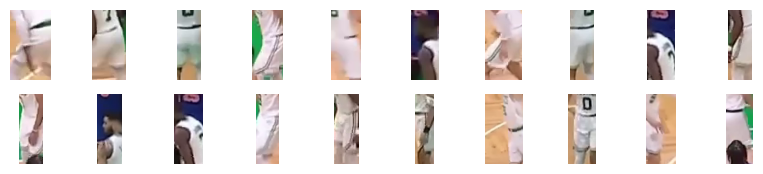


--- CLUSTER 1 --- (Inspect these images)


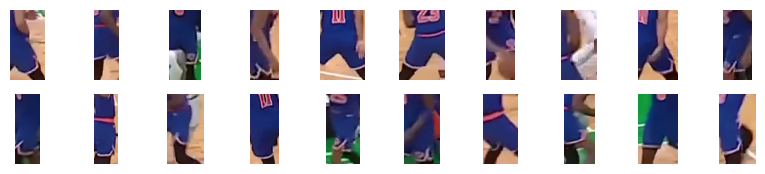

In [ ]:
# Cell 4a: Train the classifier and display results
import numpy as np
from tqdm import tqdm
from sports.common.team import TeamClassifier

def shrink_boxes(xyxy: np.ndarray, scale: float) -> np.ndarray:
    """Shrinks bounding boxes to focus on the jersey."""
    x1, y1, x2, y2 = xyxy[:, 0], xyxy[:, 1], xyxy[:, 2], xyxy[:, 3]
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
    w, h = (x2 - x1) * scale, (y2 - y1) * scale
    new_x1, new_y1 = cx - w / 2, cy - h / 2
    new_x2, new_y2 = cx + w / 2, cy + h / 2
    return np.stack([new_x1, new_y1, new_x2, new_y2], axis=1)

# 1. Collect player crops from all videos
print("Collecting player crops for team clustering...")
crops = []
for video_path in sv.list_files_with_extensions(SOURCE_VIDEO_DIRECTORY, extensions=["mp4"]):
    frame_generator = sv.get_video_frames_generator(source_path=str(video_path), stride=30)
    for frame in tqdm(frame_generator, desc=f"Processing {video_path.name}"):
        result = PLAYER_DETR_MODEL.infer(frame, confidence=0.4, iou_threshold=0.9, class_agnostic_nms=True)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]
        boxes = shrink_boxes(xyxy=detections.xyxy, scale=0.4)
        for box in boxes:
            crops.append(sv.crop_image(frame, box))

# 2. Train the team classifier
print("Training team classifier...")
team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)
teams = team_classifier.predict(crops)

# 3. Display the results for manual verification
team_0 = [crop for crop, team in zip(crops, teams) if team == 0]
team_1 = [crop for crop, team in zip(crops, teams) if team == 1]

print("\n--- CLUSTER 0 --- (Inspect these images)")
sv.plot_images_grid(images=team_0[:20], grid_size=(2, 10), size=(10, 2))
print("\n--- CLUSTER 1 --- (Inspect these images)")
sv.plot_images_grid(images=team_1[:20], grid_size=(2, 10), size=(10, 2))

In [ ]:
# Cell 4b: Manually assign team names
#
# IMPORTANT: Look at the image grids from the cell above.
# Decide which cluster (0 or 1) is which team,
# then uncomment the correct dictionary below.
#

TEAM_NAMES = {
    0: "New York Knicks",
    1: "Boston Celtics",
}

# TEAM_NAMES = {
#     0: "Boston Celtics",
#     1: "New York Knicks",
# }

print("Team names assigned:")
print(f"Cluster 0 -> {TEAM_NAMES[0]}")
print(f"Cluster 1 -> {TEAM_NAMES[1]}")

Team names assigned:
Cluster 0 -> New York Knicks
Cluster 1 -> Boston Celtics


In [ ]:
print("Uninstalling 'flash-attn' to fall back to a compatible mode...")
!pip uninstall -y flash-attn
print("Uninstall complete.")

Uninstalling 'flash-attn' to fall back to a compatible mode...
Uninstall complete.


In [ ]:
import cv2
import numpy as np
from typing import Dict, List, Optional, Union, Iterable, Tuple
from IPython.display import Video

# --- 1. Helper Functions and Classes ---

def shrink_boxes(xyxy: np.ndarray, scale: float) -> np.ndarray:
    """Shrinks bounding boxes to focus on the jersey."""
    x1, y1, x2, y2 = xyxy[:, 0], xyxy[:, 1], xyxy[:, 2], xyxy[:, 3]
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
    w, h = (x2 - x1) * scale, (y2 - y1) * scale
    new_x1, new_y1 = cx - w / 2, cy - h / 2
    new_x2, new_y2 = cx + w / 2, cy + h / 2
    return np.stack([new_x1, new_y1, new_x2, new_y2], axis=1)

def xyxy_to_mask(boxes: np.ndarray, resolution_wh: Tuple[int, int]) -> np.ndarray:
    """Converts bounding boxes to boolean masks."""
    width, height = resolution_wh
    n = boxes.shape[0]
    masks = np.zeros((n, height, width), dtype=bool)
    for i, (x_min, y_min, x_max, y_max) in enumerate(boxes):
        x_min, y_min = max(0, int(x_min)), max(0, int(y_min))
        x_max, y_max = min(width - 1, int(x_max)), min(height - 1, int(y_max))
        if x_max >= x_min and y_max >= y_min:
            masks[i, y_min:y_max + 1, x_min:x_max + 1] = True
    return masks

def coords_above_threshold(matrix: np.ndarray, threshold: float) -> List[Tuple[int, int]]:
    """Finds all (row, col) pairs in a matrix above a threshold."""
    rows, cols = np.where(np.asarray(matrix) > threshold)
    pairs = list(zip(rows.tolist(), cols.tolist()))
    pairs.sort(key=lambda rc: matrix[rc[0], rc[1]], reverse=True)
    return pairs

def filter_segments_by_distance(mask: np.ndarray, distance_threshold: float = 300) -> np.ndarray:
    """Keeps the main segment of a mask and removes small, distant artifacts."""
    mask_uint8 = mask.astype(np.uint8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)
    if num_labels <= 1: return mask.copy()
    main_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    main_centroid = centroids[main_label]
    filtered_mask = np.zeros_like(mask, dtype=bool)
    for label in range(1, num_labels):
        if np.linalg.norm(centroids[label] - main_centroid) <= distance_threshold:
            filtered_mask[labels == label] = True
    return filtered_mask

Value = Union[int, str, None]
class PropertyValidator:
    """Validates a property (like a number) after N consecutive identical reports."""
    def __init__(self, n_consecutive: int):
        self.n = n_consecutive
        self._streak: Dict[int, int] = {}
        self._last: Dict[int, Optional[str]] = {}
        self._validated: Dict[int, Optional[str]] = {}

    def _normalize(self, value: Value) -> Optional[str]:
        if value is None: return None
        s = str(value).strip()
        return s if s else None

    def update(self, tracker_ids: List[int], values: List[Value]):
        for tid, raw in zip(tracker_ids, values):
            if tid in self._validated and self._validated.get(tid) is not None: continue
            val = self._normalize(raw)
            if val is None:
                self._streak[tid] = 0
                continue
            if self._last.get(tid) == val:
                self._streak[tid] = self._streak.get(tid, 0) + 1
            else:
                self._streak[tid] = 1
                self._last[tid] = val
            if self._streak.get(tid, 0) >= self.n:
                self._validated[tid] = self._last.get(tid)

    def get_validated(self, tracker_ids: Iterable[int]) -> List[Optional[str]]:
        return [self._validated.get(tid) for tid in tracker_ids]

print("Helper utilities defined.")

# --- 2. Define Output Paths ---
TARGET_VIDEO_PATH = HOME / f"{SOURCE_VIDEO_PATH.stem}-result.mp4"
TARGET_VIDEO_COMPRESSED_PATH = HOME / f"{SOURCE_VIDEO_PATH.stem}-result-compressed.mp4"

# --- 3. Initialize Validators and Annotators ---
print("Initializing annotators...")
number_validator = PropertyValidator(n_consecutive=3)
# !! THIS IS THE FIX !!
team_validator = PropertyValidator(n_consecutive=1)
# !! END OF FIX !!

video_info = sv.VideoInfo.from_video_path(str(SOURCE_VIDEO_PATH))
team_colors = sv.ColorPalette.from_hex([
    TEAM_COLORS[TEAM_NAMES[0]],
    TEAM_COLORS[TEAM_NAMES[1]]
])
team_mask_annotator = sv.MaskAnnotator(
    color=team_colors, opacity=0.5, color_lookup=sv.ColorLookup.INDEX)
team_label_annotator = sv.RichLabelAnnotator(
    font_path=f"{HOME}/fonts/Staatliches-Regular.ttf",
    font_size=40, color=team_colors, text_color=sv.Color.WHITE,
    text_position=sv.Position.BOTTOM_CENTER,
    color_lookup=sv.ColorLookup.INDEX)

# --- 4. Initialize Tracker (First Frame Setup) ---
print("Initializing tracker on the first frame...")
frame_generator = sv.get_video_frames_generator(str(SOURCE_VIDEO_PATH))
frame = next(frame_generator)

# Detect players and determine their teams
result = PLAYER_DETR_MODEL.infer(frame, confidence=0.4, iou_threshold=0.9, class_agnostic_nms=True)[0]
detections = sv.Detections.from_inference(result)
detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]
TRACKER_IDS = list(range(1, len(detections.class_id) + 1))
boxes = shrink_boxes(xyxy=detections.xyxy, scale=0.4)
crops = [sv.crop_image(frame, box) for box in boxes]
TEAMS = np.array(team_classifier.predict(crops))
team_validator.update(tracker_ids=TRACKER_IDS, values=TEAMS)

# Prompt SAM2.1 tracker
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    sam_predictor.load_first_frame(frame)
    for xyxy, tracker_id in zip(detections.xyxy, TRACKER_IDS):
        sam_predictor.add_new_prompt(frame_idx=0, obj_id=tracker_id, bbox=np.array([xyxy]))

# --- 5. Main Processing Loop (Process and Write) ---
# This loop processes one frame and writes it immediately to save RAM
print("Starting main video processing loop...")
frame_generator = sv.get_video_frames_generator(str(SOURCE_VIDEO_PATH))
with sv.VideoSink(str(TARGET_VIDEO_PATH), video_info) as sink:
    for index, frame in tqdm(enumerate(frame_generator), desc="Processing and writing video", total=video_info.total_frames):

        frame_h, frame_w, *_ = frame.shape

        # A. Track players
        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
            tracker_ids, mask_logits = sam_predictor.track(frame)
            masks = (mask_logits > 0.0).cpu().numpy().squeeze().astype(bool)
            # Handle cases with single vs. multiple trackers
            if len(masks.shape) == 2:
                masks = np.array([masks])
            player_masks = np.array([filter_segments_by_distance(mask) for mask in masks])
            player_detections = sv.Detections(
                xyxy=sv.mask_to_xyxy(masks=player_masks),
                mask=player_masks,
                tracker_id=np.array(tracker_ids)
            )

        # B. Recognize numbers (every 5 frames for efficiency)
        if index % 5 == 0:
            result = PLAYER_DETR_MODEL.infer(frame, confidence=0.4, iou_threshold=0.9)[0]
            number_detections = sv.Detections.from_inference(result)
            number_detections = number_detections[number_detections.class_id == NUMBER_CLASS_ID]

            if len(number_detections) > 0:
                number_detections.mask = xyxy_to_mask(boxes=number_detections.xyxy, resolution_wh=(frame_w, frame_h))
                number_crops = [sv.crop_image(frame, xyxy) for xyxy in sv.clip_boxes(sv.pad_boxes(xyxy=number_detections.xyxy, px=10), (frame_w, frame_h))]
                numbers = [NUMBER_OCR_MODEL.predict(crop, NUMBER_OCR_MODEL_PROMPT)[0] for crop in number_crops]

                # Match numbers to players using mask Intersection over Smaller area (IoS)
                iou = sv.mask_iou_batch(player_masks, number_detections.mask, sv.OverlapMetric.IOS)
                pairs = coords_above_threshold(iou, 0.9)
                if len(pairs) > 0:
                    player_indices, number_indices = zip(*pairs)
                    matched_tracker_ids = [player_detections.tracker_id[i] for i in player_indices]
                    matched_numbers = [numbers[i] for i in number_indices]
                    number_validator.update(tracker_ids=matched_tracker_ids, values=matched_numbers)

        # C. Annotate the frame
        player_detections = player_detections[player_detections.area > 100] # Filter small, noisy detections
        if len(player_detections) == 0:
            sink.write_frame(frame) # Write the raw frame if no detections
            continue

        teams_validated = team_validator.get_validated(tracker_ids=player_detections.tracker_id)
        # Filter out any None values if trackers are new or lost
        valid_indices = [i for i, team in enumerate(teams_validated) if team is not None]

        player_detections = player_detections[valid_indices]
        if len(player_detections) == 0:
            sink.write_frame(frame)
            continue

        teams = np.array([teams_validated[i] for i in valid_indices]).astype(int)
        numbers = np.array(number_validator.get_validated(tracker_ids=player_detections.tracker_id))

        labels = []
        for number, team in zip(numbers, teams):
            team_name = TEAM_NAMES[team]
            if number:
                player_name = TEAM_ROSTERS[team_name].get(number, "")
                labels.append(f"#{number} {player_name}")
            else:
                labels.append(team_name) # Fallback to team name if no number

        annotated_frame = frame.copy()
        annotated_frame = team_mask_annotator.annotate(scene=annotated_frame, detections=player_detections, custom_color_lookup=teams)
        annotated_frame = team_label_annotator.annotate(scene=annotated_frame, detections=player_detections, labels=labels, custom_color_lookup=teams)

        # D. Write the single annotated frame to the video file
        sink.write_frame(annotated_frame)

print("\n✅ Video processing and writing complete.")

# --- 6. Compress and Display ---
print("Compressing video for Colab display...")
!ffmpeg -y -loglevel error -i {TARGET_VIDEO_PATH} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED_PATH}

print("Displaying compressed video:")
Video(TARGET_VIDEO_COMPRESSED_PATH, embed=True, width=1080)

Helper utilities defined.
Initializing annotators...
Initializing tracker on the first frame...


Embedding extraction: 1it [00:00,  3.65it/s]


Starting main video processing loop...


Processing and writing video:   0%|          | 0/238 [00:04<?, ?it/s]


RuntimeError: FlashAttention only supports Ampere GPUs or newer.

In [ ]:
import os
from google.colab import userdata
from pathlib import Path
import torch

# 1. Configure API Keys
# IMPORTANT: Go to the 'Secrets' (🔑) tab in Colab and add:
# 1. HF_TOKEN = "your_hugging_face_token"
# 2. ROBOFLOW_API_KEY = "your_roboflow_api_key"
try:
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
    os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")
    print("API keys loaded successfully.")
except Exception as e:
    print("Could not load API keys. Please set them up in Colab Secrets (🔑).")
    print("Required secrets: 'HF_TOKEN' and 'ROBOFLOW_API_KEY'")

# 2. Check for GPU
!nvidia-smi

# 3. Set home directory and ONNX provider
HOME = Path.cwd()
print("HOME:", HOME)
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

# 4. Install SAM2 (Segment Anything Model 2) for tracking
print("Installing SAM2...")
!git clone https://github.com/Gy920/segment-anything-2-real-time.git
%cd {HOME}/segment-anything-2-real-time
!pip install -e . -q
!python setup.py build_ext --inplace
!(cd checkpoints && bash download_ckpts.sh)
%cd {HOME}

# 5. Install all other required Python packages
print("Installing other dependencies...")
!pip install -q gdown inference-gpu supervision transformers num2words
!pip install -q git+https://github.com/roboflow/sports.git@feat/basketball

# !! THIS IS A FIX !!
# We uninstall 'flash-attn' to prevent the 'RuntimeError' on older GPUs.
!pip install -q flash-attn --no-build-isolation
!pip uninstall -y flash-attn
print("Uninstalled flash-attn to ensure compatibility.")

print("\n✅ All installations are complete.")
print("➡️ IMPORTANT: After this block, go to 'Runtime' -> 'Restart session', then run all blocks *after* this one.")

API keys loaded successfully.
Tue Oct 28 12:10:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------

In [ ]:
import os
from pathlib import Path
from google.colab import userdata
import supervision as sv

# Re-define HOME and load API keys after restart
HOME = Path.cwd()
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

# 1. Download sample videos and fonts
SOURCE_VIDEO_DIRECTORY = HOME / "source"
!gdown -q https://drive.google.com/drive/folders/1eDJYqQ77Fytz15tKGdJCMeYSgmoQ-2-H -O {SOURCE_VIDEO_DIRECTORY} --folder
!gdown -q https://drive.google.com/drive/folders/1RBjpI5Xleb58lujeusxH0W5zYMMA4ytO -O {HOME / "fonts"} --folder
print("Sample videos and fonts downloaded.")

# 2. Define the source video path you want to process
SOURCE_VIDEO_PATH = SOURCE_VIDEO_DIRECTORY / "boston-celtics-new-york-knicks-game-1-q1-04.28-04.20.mp4"
print(f"Processing video: {SOURCE_VIDEO_PATH.name}")

# 3. Define Team Rosters and Colors
TEAM_ROSTERS = {
  "New York Knicks": {
    "55": "Hukporti", "1": "Payne", "0": "Wright", "11": "Brunson", "3": "Hart",
    "32": "Towns", "44": "Shamet", "25": "Bridges", "2": "McBride",
    "23": "Robinson", "8": "Anunoby", "4": "Dadiet", "5": "Achiuwa", "13": "Kolek"
  },
  "Boston Celtics": {
    "42": "Horford", "55": "Scheierman", "9": "White", "20": "Davison",
    "7": "Brown", "0": "Tatum", "27": "Walsh", "4": "Holiday", "8": "Porzingis",
    "40": "Kornet", "88": "Queta", "11": "Pritchard", "30": "Hauser",
    "12": "Craig", "26": "Tillman"
  }
}

TEAM_COLORS = {
    "New York Knicks": "#006BB6",
    "Boston Celtics": "#007A33"
}

# 4. Define class IDs for players
PLAYER_CLASS_IDS = [3, 4, 5, 6, 7] # player, player-in-possession, etc.
NUMBER_CLASS_ID = 2